In [1]:
!pip install hyperopt
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 6.2 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import shap
from sklearn.preprocessing import StandardScaler


from google.colab import drive
colab = True
drive.mount('/content/drive')
data_path = '/content/drive/Shared drives/MSD 23 Drive/Datasets'

print('Data path: ', data_path)

Mounted at /content/drive
Data path:  /content/drive/Shared drives/MSD 23 Drive/Datasets


In [5]:
df = pd.read_csv(data_path + '/prevalence_facilities_cleaned.csv')

In [6]:
# Remove all years after 2019 - missing values
df = df[df['year'] < 2020]
# drop OUDRATE column - only contains values for specific year
df = df.drop(columns = ['OUDRATE'])

In [7]:
# Check overall number of NaNs now
df.isna().sum().sum()

0

In [8]:
# features to use as predictors
cont_cols = ['ASSESSMENT', 
             'TESTING', 
             'TRANSITION', 
             'ANCILLARY', 
             'OTHER_SRVC']

binar_cols = ['DETOX',  
              'TREATMT',  
              'HOSPITAL',  
              'SRVC75',  
              'SRVC71',  
              'SRVC108',  
              'SRVC85',  
              'SRVC87',  
              'SRVC86',  
              'OTP',  
              'OPIOIDMAINT',
              'OPIOIDWDRAW',  
              'OPIOIDDETOX',  
              'OPIOIDNAL',  
              'DUI_DWI',  
              'ONLYDUI',  
              'SIGNLANG',  
              'SRVC30',  
              'SRVC34',  
              'SRVC33',  
              'SRVC64',  
              'SRVC63',
              'SRVC62',  
              'SRVC113',  
              'SRVC114',  
              'SRVC115',  
              'SRVC61',  
              'SRVC31',  
              'SRVC32',  
              'SRVC116',  
              'CTYPE4',  
              'CTYPE7',  
              'CTYPERC1',  
              'CTYPERC3',
    'CTYPERC4',  'CTYPE1',  'CTYPE6',  'CTYPEML',  'CTYPEOP',  'CTYPE2',  'CTYPE3', 'FEESCALE',  'PAYASST',  'EARMARK',
    'REVCHK3',  'REVCHK1',  'REVCHK8',  'REVCHK5',  'REVCHK10',  'REVCHK15',  'REVCHK2',  'REVCHK17',
    'LOC5',  'LICEN',  'ACCRED',  'OWNERSHP_Federal Government',  'OWNERSHP_Local, county or community government', 
    'OWNERSHP_Private non-profit organization',     'OWNERSHP_Private-for-profit organization',  'OWNERSHP_State government',  'OWNERSHP_Tribal Government']

features = cont_cols + binar_cols + ['facility_density']
features_targets = features + ['NEED1', 'NEED2', 'NEED3']

In [9]:
df = df.reset_index().drop(columns = 'index')

In [10]:
X = df[features]
print(len(X.columns))

67


In [11]:
Z = df[features_targets]
print(len(Z.columns))

70


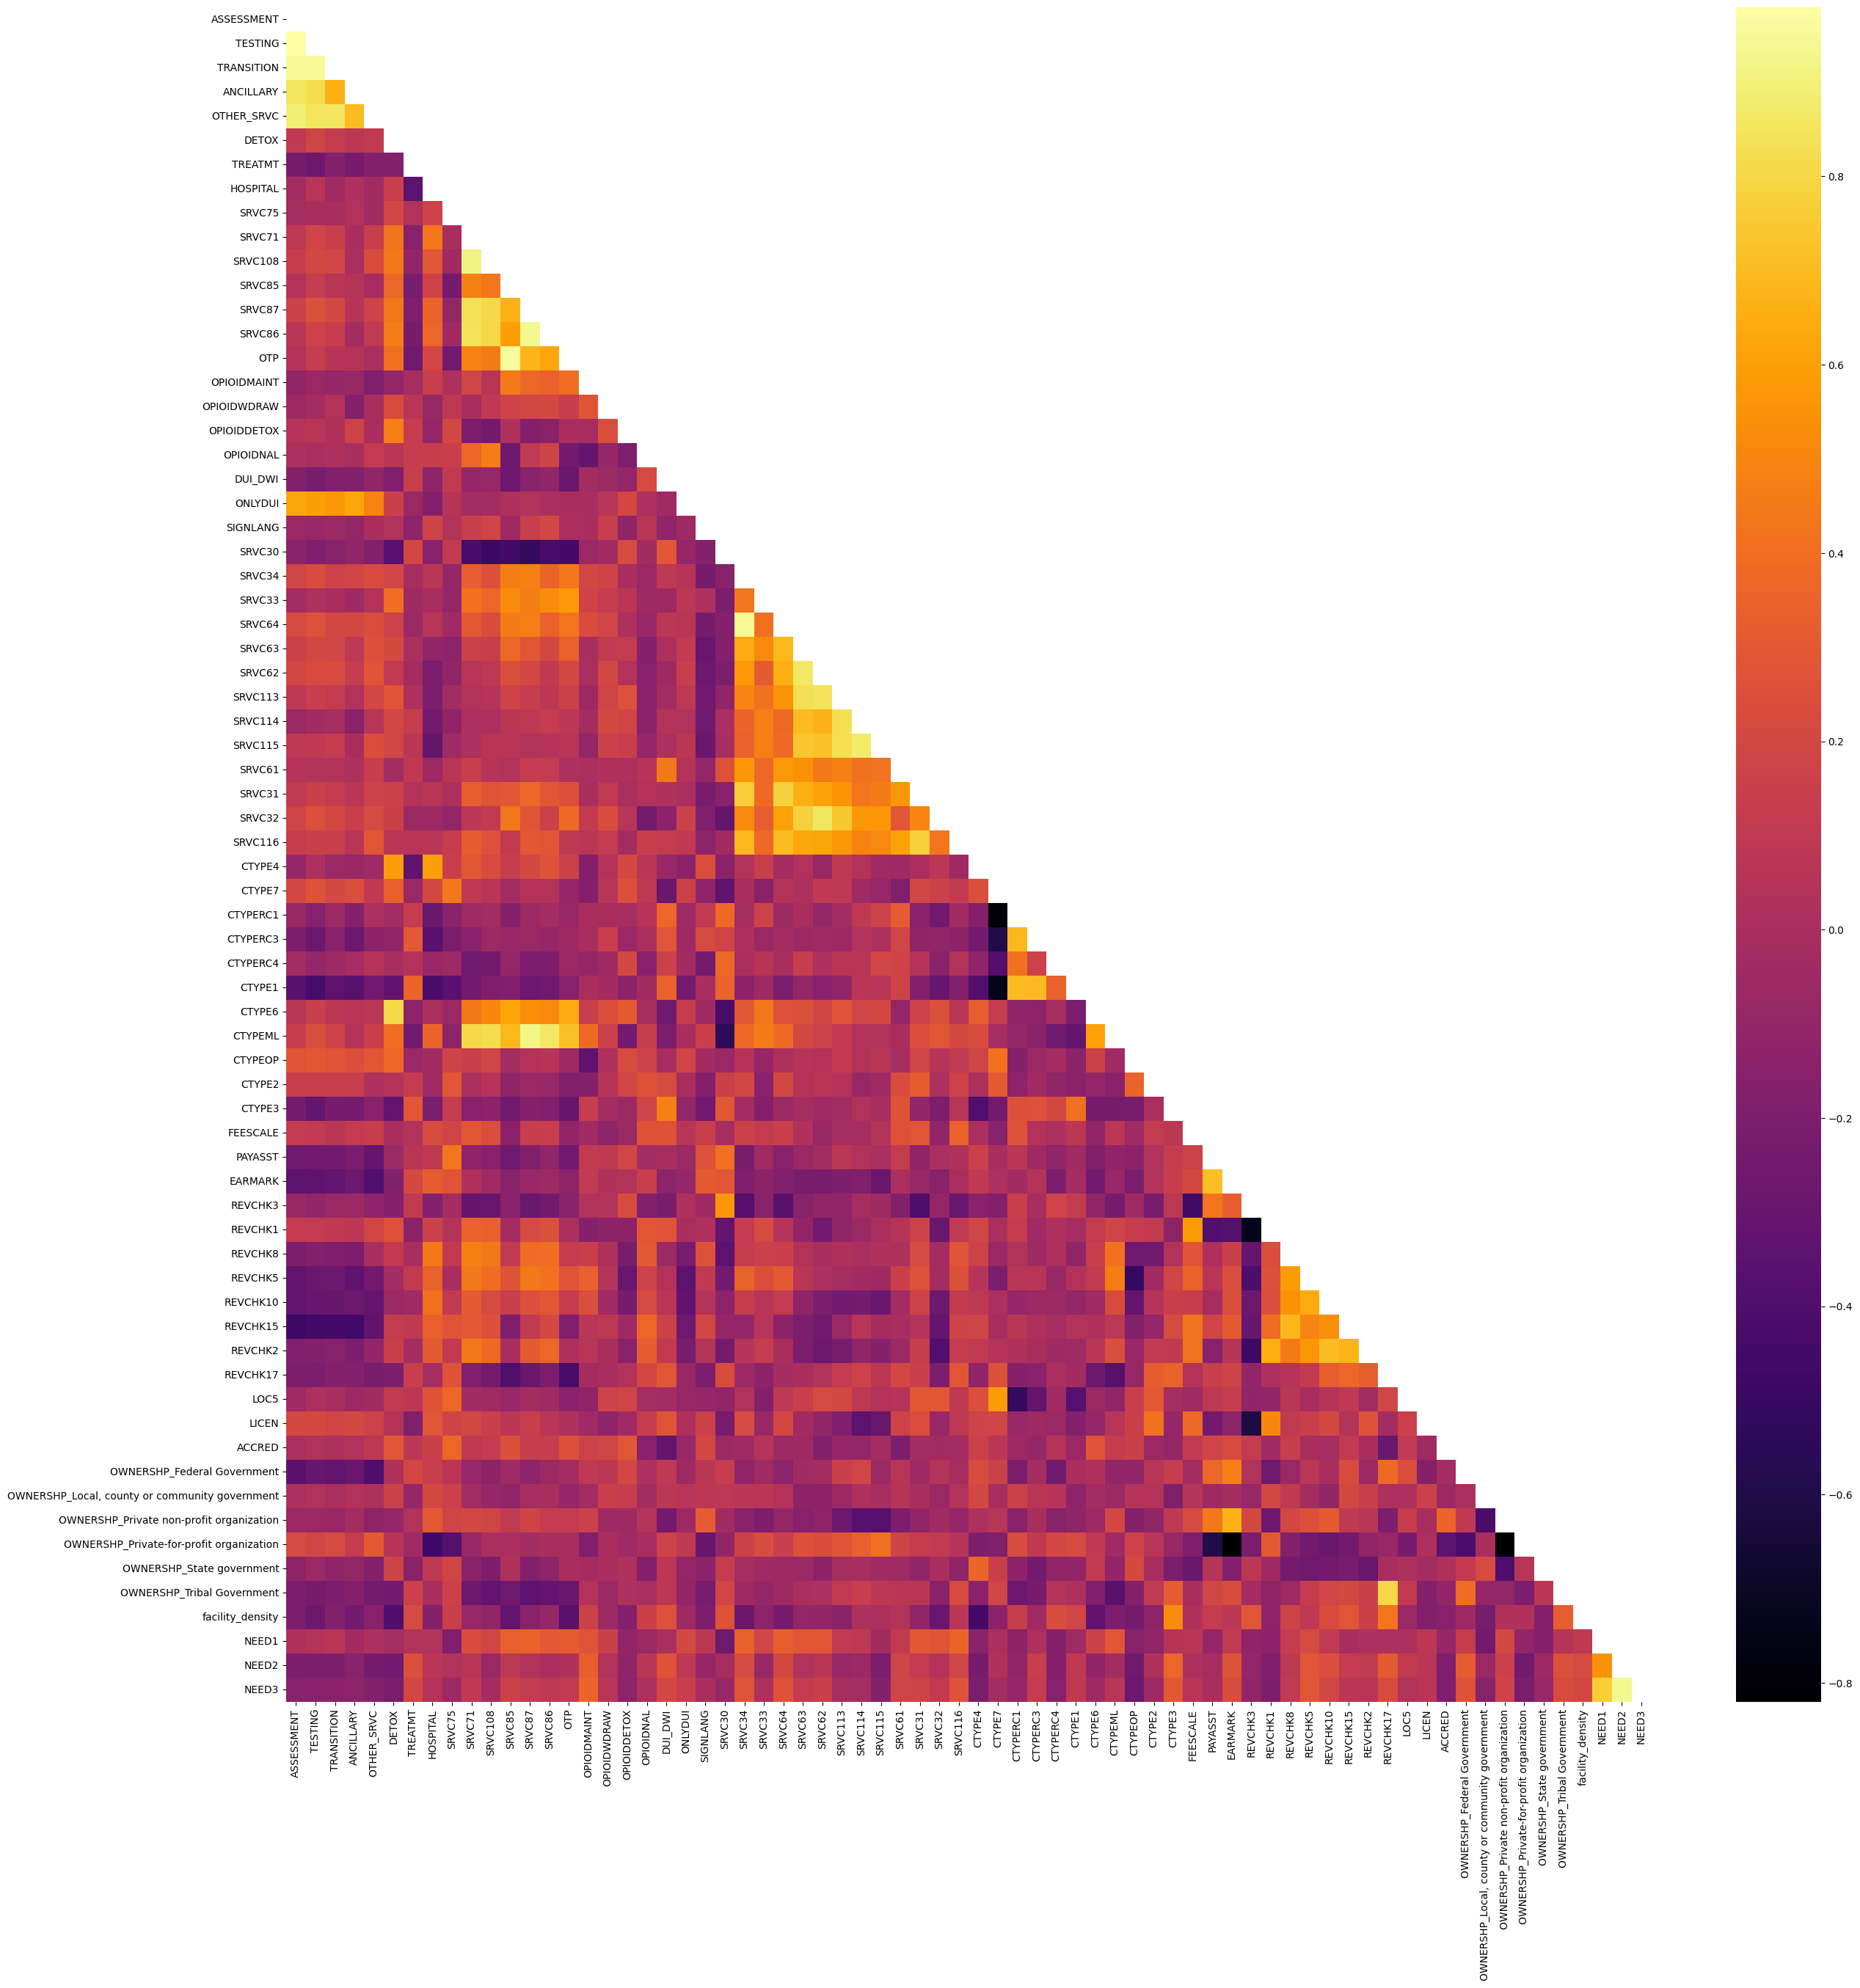

In [12]:
# creating mask
mask = np.triu(np.ones_like(Z.corr()))
 
# plotting a triangle correlation heatmap
plt.figure(figsize = (30, 30))
dataplot = sns.heatmap(Z.corr(), cmap="inferno", annot=False, mask=mask)
plt.show()

In [13]:
y_targets = [df[NEED] for NEED in ['NEED1', 'NEED2', 'NEED3']] 

Training model to predict target variable:  NEED1
Cross-validated negative root mean squared error score:  0.0033009728551695464
Evaluation on held-out test-set:  0.004561759914066971


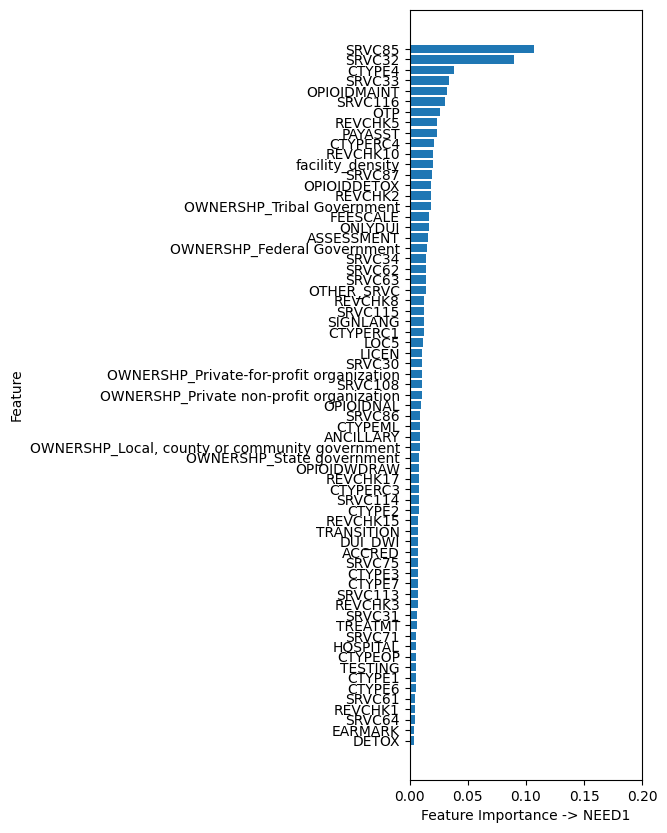

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


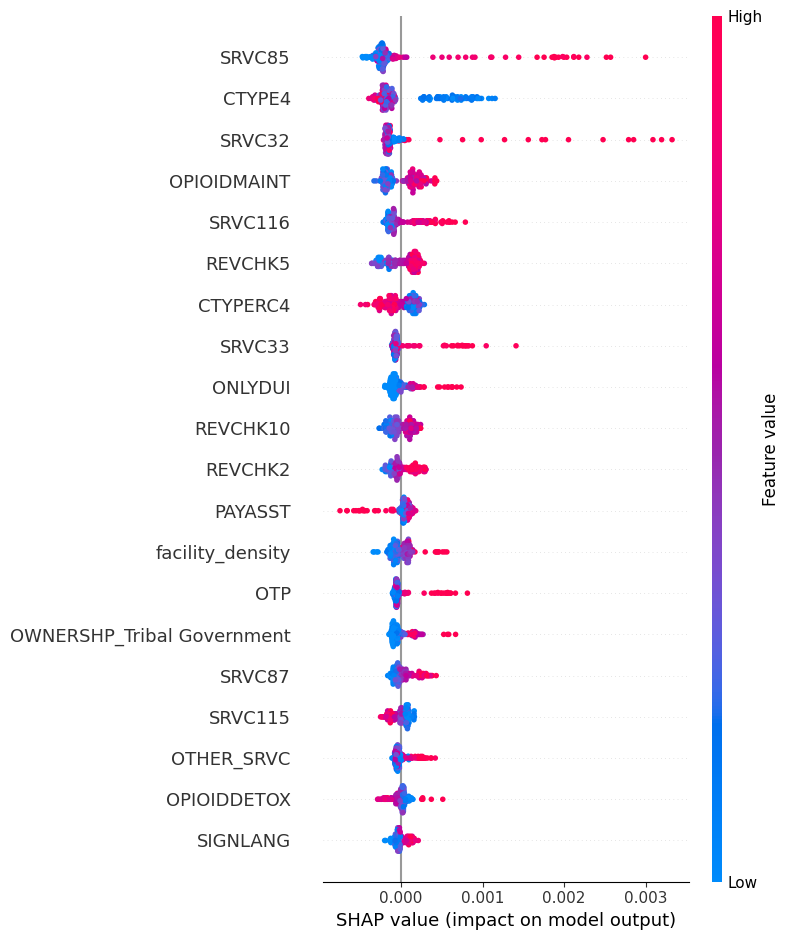

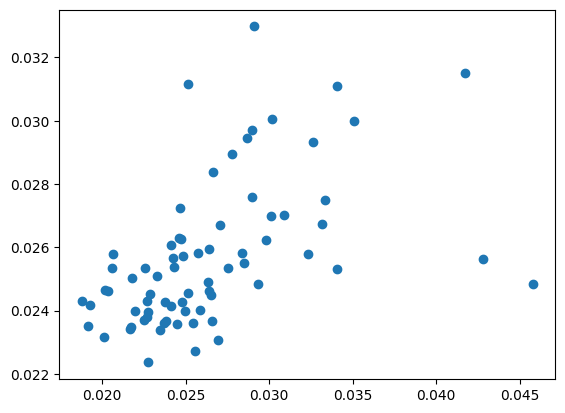

Training model to predict target variable:  NEED2
Cross-validated negative root mean squared error score:  0.006358046196768785
Evaluation on held-out test-set:  0.006330459767452994


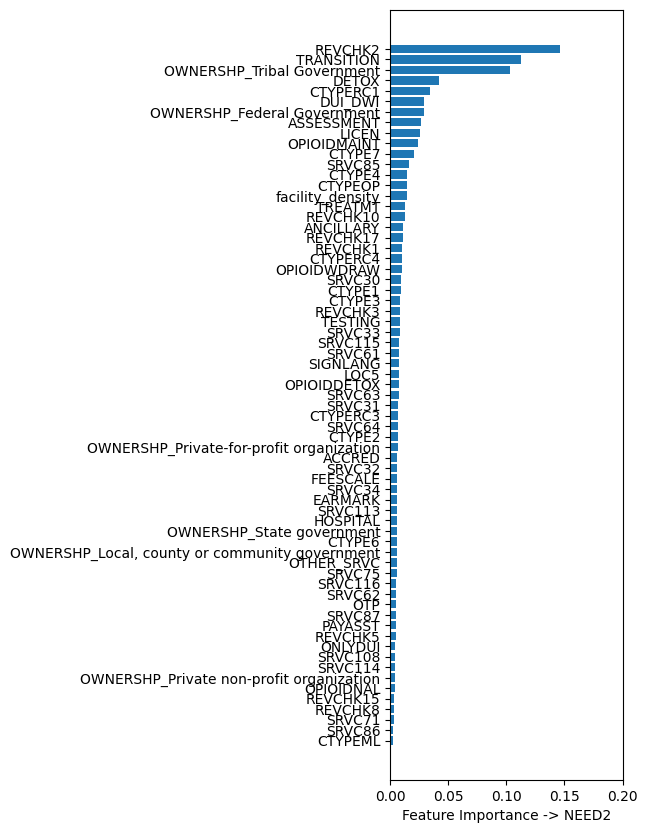

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


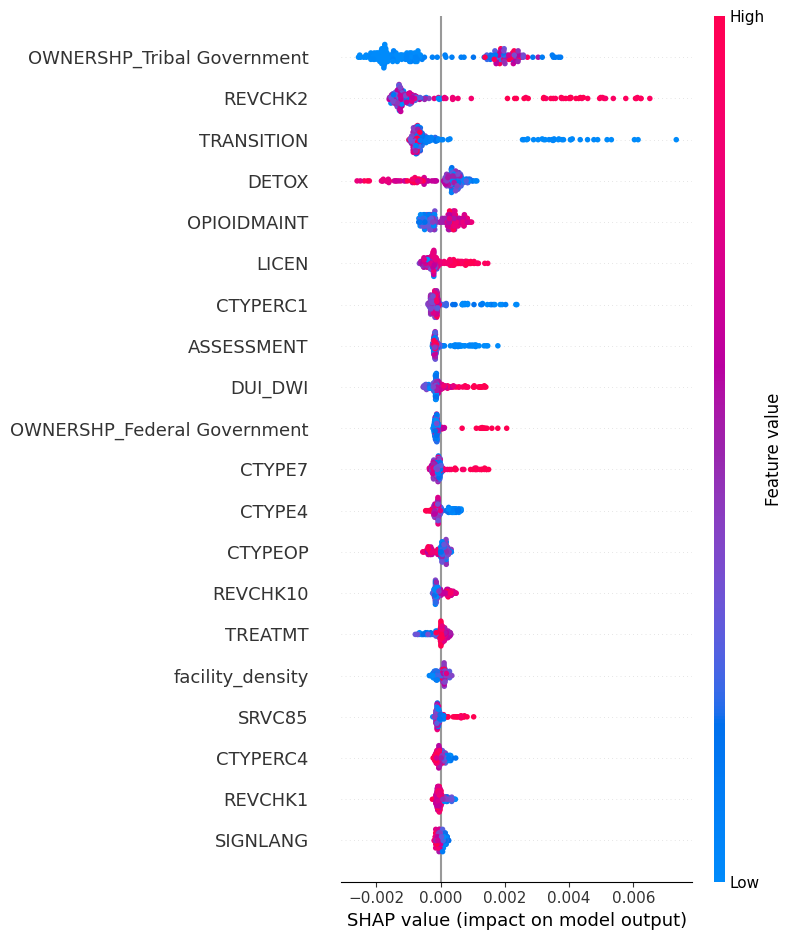

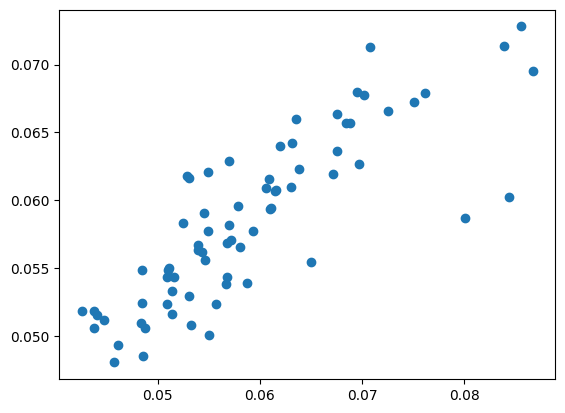

Training model to predict target variable:  NEED3
Cross-validated negative root mean squared error score:  0.007379437662994566
Evaluation on held-out test-set:  0.009480828818161549


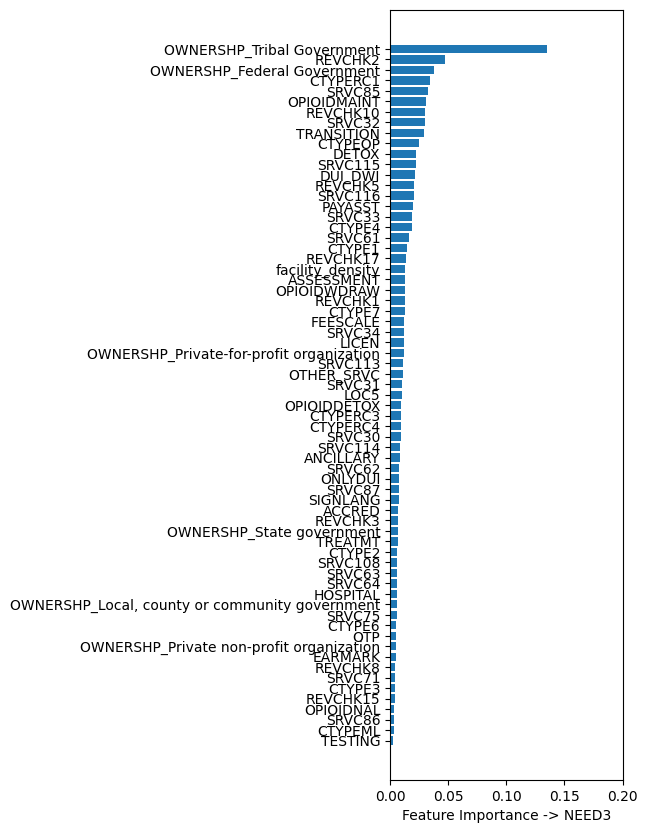

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


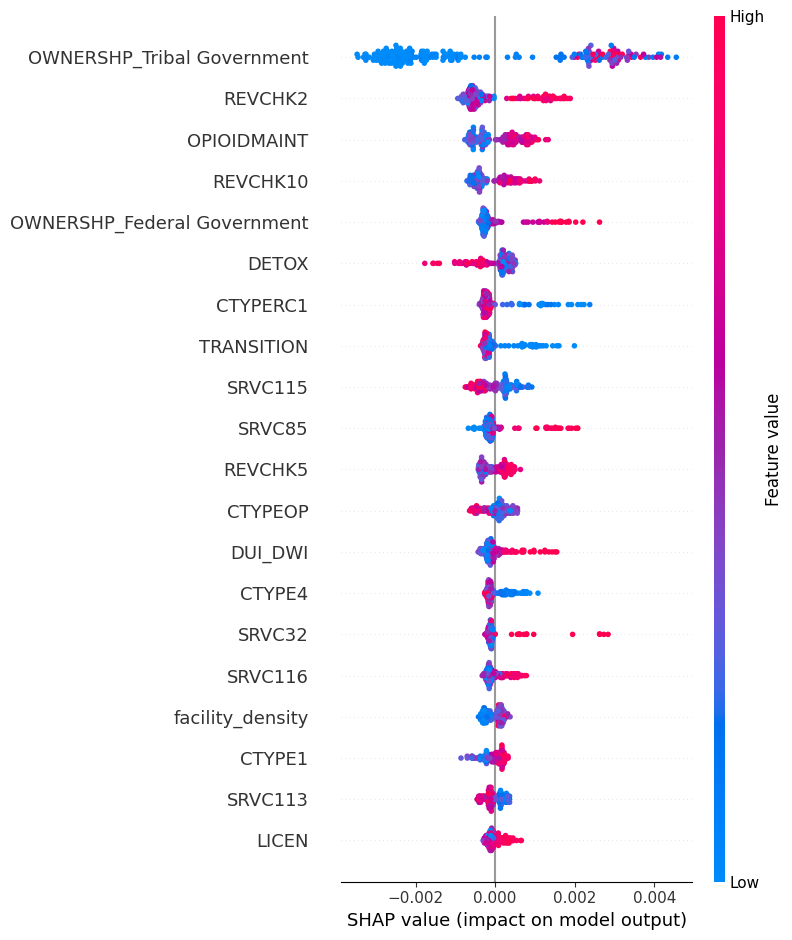

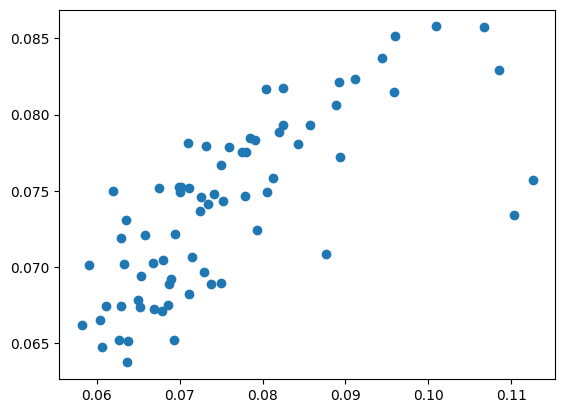

In [14]:
test_rmse = []
for target_label, index in zip(['NEED1', 'NEED2', 'NEED3'], range(3)):
    print('Training model to predict target variable: ', target_label)
    # Fetch target from df
    y = df[target_label]
    # train-test split - test is 35% of overall dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, random_state=0)
    # Standard Scaling
    scaler = StandardScaler()
    # fit on training data
    scaler.fit(X_train)
    # transform both training and test data
    scaler.transform(X_train)
    scaler.transform(X_test)
    # Instantiate model
    model = RandomForestRegressor(n_estimators=300,random_state=0)
    # Use 10-fold cross-val to get estimate of training RMSE
    score = cross_val_score(model,
                            X_train,
                            y_train,
                            cv=10,
                            scoring='neg_mean_squared_error')
    print("Cross-validated negative root mean squared error score: ", np.sqrt(-score.mean()))
    # Fit the actual regressor
    model.fit(X_train, y_train)
    # predict X_test
    y_pred = model.predict(X_test)
    # get test set RMSE
    print('Evaluation on held-out test-set: ', np.sqrt(mean_squared_error(y_test, y_pred)))
    test_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    
    sorted_indices = model.feature_importances_.argsort()    
    
    plt.figure(figsize = (3, 10))
    plt.barh([features[index] for index in sorted_indices], model.feature_importances_[sorted_indices])
    #plt.bar(features, rf.feature_importances_)
    if index == 0: 
        plt.ylabel('Feature') 
    plt.xlabel('Feature Importance -> ' + target_label)
    plt.xlim([0, 0.2])
    #plt.yticks(rotation = 90); 
    plt.show()
    
    # Get SHAP values from rf model
    explainer = shap.Explainer(model)
    # Explain model
    shap_values = explainer(X)
    # Beeswarm plot - SHAP values
    shap.summary_plot(shap_values, X)
    
    # Plot y_pred vs y_test
    plt.scatter(y_test, y_pred)
    plt.show()

In [15]:
# % RMSE of model trained to predict NEED1 compared to mean value of NEED1
100 * test_rmse[0] / df['NEED1'].mean()

17.818807905252296

In [16]:
# % RMSE of model trained to predict NEED2 compared to mean value of NEED2
100 * test_rmse[1] / df['NEED2'].mean()

10.840294979520818

In [17]:
# % RMSE of model trained to predict NEED3 compared to mean value of NEED3
100 * test_rmse[2] / df['NEED3'].mean()

12.720019610407304

In [24]:
y = df['NEED3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, random_state=0)

In [25]:
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from sklearn.metrics import mean_squared_error

space = {'criterion': hp.choice('criterion', ['squared_error', 'friedman_mse']),
        'max_depth': hp.quniform('max_depth', 10, 100, 1),
        'max_features': hp.choice('max_features', ['sqrt','log2', None]),
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1000])
    }

def objective(space):
    model = RandomForestRegressor(criterion = space['criterion'], 
                                  max_depth = int(space['max_depth']),
                                  max_features = space['max_features'],
                                  min_samples_leaf = space['min_samples_leaf'],
                                  min_samples_split = space['min_samples_split'],
                                  n_estimators = space['n_estimators'], 
                                 )
    
    neg_mse = cross_val_score(model, X_train, y_train, 
                           cv = 5, scoring = 'neg_mean_squared_error').mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -neg_mse, 'status': STATUS_OK }


In [26]:
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)
best

100%|██████████| 80/80 [06:43<00:00,  5.04s/trial, best loss: 5.6694929435408644e-05]


{'criterion': 0,
 'max_depth': 83.0,
 'max_features': 0,
 'min_samples_leaf': 0.013952403727479662,
 'min_samples_split': 0.036775184046655036,
 'n_estimators': 2}

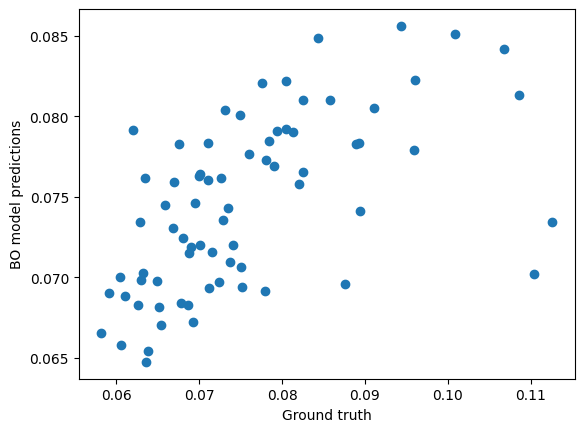

14.270114338620772


In [27]:
bo_rf = RandomForestRegressor(criterion = 'friedman_mse', 
                                  max_depth = 62,
                                  max_features = 'log2',
                                  min_samples_leaf = 0.030109381335711463,
                                  min_samples_split = 0.06510050273823399,
                                  n_estimators = 10,
                                 )

bo_rf.fit(X_train, y_train)

bo_pred = bo_rf.predict(X_test)

plt.scatter(y_test, bo_pred)
plt.ylabel('BO model predictions')
plt.xlabel('Ground truth')
plt.show()

print(100* np.sqrt(mean_squared_error(bo_pred, y_test))/y.mean())

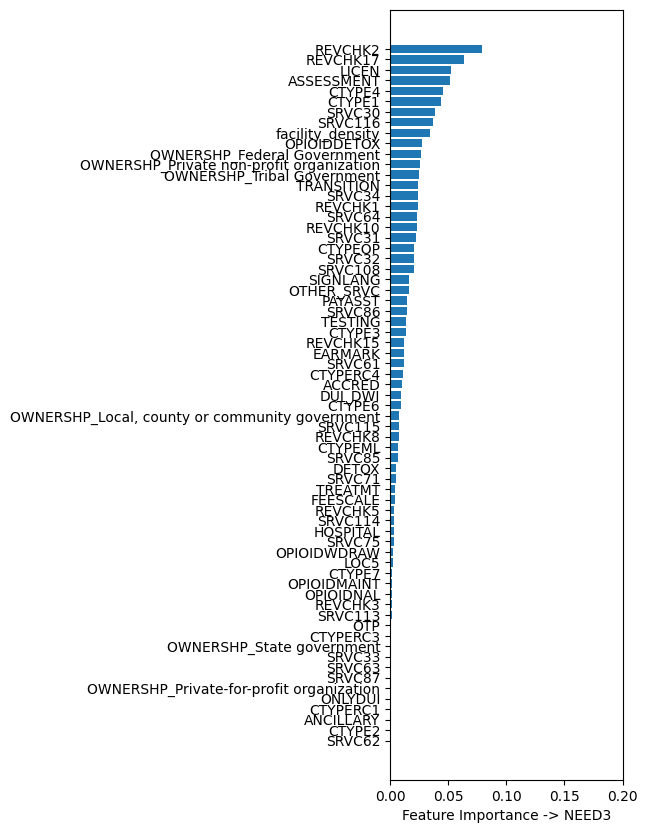

In [23]:
sorted_indices = bo_rf.feature_importances_.argsort()    
    
plt.figure(figsize = (3, 10))
plt.barh([features[index] for index in sorted_indices], bo_rf.feature_importances_[sorted_indices])
#plt.bar(features, rf.feature_importances_)
if index == 0: 
    plt.ylabel('Feature') 
plt.xlabel('Feature Importance -> NEED3')
plt.xlim([0, 0.2])
#plt.yticks(rotation = 90); 
plt.show()